# Exerise 2

The aims of this execise are to:
 - Make your first recommender by implementing a user-based CF (c.f. Lecture 4).
 - Make your first recommendations using Spotlight recommender toolkit on explicit data (Lecture 8)
 - Develop and evaluate baseline recommender systems (c.f. Lecture 3)
 - Start to think about explicit vs implicit learners
 - Evaluate your results using Spotlight (Lecture 6 & 7)

This exercise builds on the lectures' material, namely Lectures 3, 4, 6, 7 and 8.

There are 10 tasks to increase your understanding of the content of the Recommender Sytems course.  Each of these tasks have corresponding questions in the quiz.

In [ ]:
#Standard setup
import pandas as pd
import numpy as np
import torch
from typing import List, Tuple, Sequence
SEED=20

We'll be using Movielens again. Let's load it in to the dataframe.


In [ ]:
!curl -o ml-latest-small.zip http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# backup location
#!curl -o ml-latest-small.zip http://www.dcs.gla.ac.uk/~craigm/recsysHM/ml-latest-small.zip
!unzip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   891k      0  0:00:01  0:00:01 --:--:--  891k
Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")

# we're going to treat userId as strings, and similarly as movies. This will prevent confusion later on.
ratings_df['userId'] =  "u" + ratings_df['userId'].astype(str)
ratings_df['movieId'] = "m" + ratings_df['movieId'].astype(str)
movies_df['movieId'] = "m" +  movies_df['movieId'].astype(str)

In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,u1,m1,4.0,964982703
1,u1,m3,4.0,964981247
2,u1,m6,4.0,964982224
3,u1,m47,5.0,964983815
4,u1,m50,5.0,964982931


In [ ]:
movies_df.head()

,movieId,title,genres
0,m1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,m2,Jumanji (1995),Adventure|Children|Fantasy
2,m3,Grumpier Old Men (1995),Comedy|Romance
3,m4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,m5,Father of the Bride Part II (1995),Comedy


# Part A. User-based CF

You can generate a matrix of ratings with the ratings_df dataframe. In the matrix, the unrated items are filled with 0 (this means they have no impact upon the calculated Cosine value).

In [ ]:
r_df_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
r_df_matrix

movieId,m1,m10,m100,m100044,m100068,m100083,m100106,m100159,m100163,m100194,m100226,m100277,m1003,m100302,m100304,m100306,m100326,m100383,m100390,m100397,m1004,m100487,m100498,m1005,m100507,m100527,m100553,m100556,m100579,m1006,m100611,m1007,m100714,m100737,m1008,m100810,m100843,m100882,m1009,m100906,...,m98836,m98908,m98961,m99,m990,m99005,m99007,m99030,m99087,m991,m99106,m99112,m99114,m99117,m99122,m99130,m99145,m99149,m99191,m993,m994,m99415,m99437,m99532,m99574,m996,m99636,m99638,m99721,m99728,m99750,m99764,m998,m99813,m99846,m99853,m999,m99910,m99917,m99992
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u96,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
total_users=len(r_df_matrix.index)
total_users

610

The left hand bold column is the [index of the dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html) - that is, an attribute of the dataframe that allows fast lookup of rows. In this case, userId has become our index column.

You can get all the index of users using the .index 

In [ ]:
r_df_matrix.index

Index(['u1', 'u10', 'u100', 'u101', 'u102', 'u103', 'u104', 'u105', 'u106',
       'u107',
       ...
       'u90', 'u91', 'u92', 'u93', 'u94', 'u95', 'u96', 'u97', 'u98', 'u99'],
      dtype='object', name='userId', length=610)

In [ ]:
user_list=r_df_matrix.index.tolist()
len(user_list)
#user_list

610

You can also use [.loc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) to access rows, by their "index". For instance, we can get all ratings of a specific user with userId=‘1’.

In [ ]:
indices=r_df_matrix.loc['u1'].values.nonzero()[0]
#indices[0][2]
indices[2]

40

User-based CF heavily relies upon Cosine similarity. We are providing a Cosine similarity implementation based on numpy operations. We also show how to use df.loc to get all the ratings of a given user from `r_df_matrix` as a Series - we then make this into a numpy array using the [.values](https://pandas.pydata.org/docs/reference/api/pandas.Series.values.html) property.


In [ ]:
def cos_sim(a, b):
  from numpy.linalg import norm
  from numpy import dot
  return dot(a, b)/(norm(a)*norm(b))

print('Cosine similarity between userId=1 and itself is:')
print(cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u1'].values))

print('Cosine similarity between userId=1 and userId=607 is:')
print(cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u607'].values))

Cosine similarity between userId=1 and itself is:
1.0
Cosine similarity between userId=1 and userId=607 is:
0.2693892401115333


## Task 1. Get the most similar users.

User-based CF is based on user-neighbourhoods. In this task, you will implement a function ` get_most_similar_users(userId : str, k : int = 10)` that will identify the userIds of the k most similar users to the specified userId, and their corresponding cosine similarities. 

In determining the most similar users, you should break ties based on their position in the array - for instance, if two users are tied as 2nd most similar user, the user who appears earlier should be 2nd, and the latter user third.

You should exclude the compared user itself when generating a list of the most similar users.

NB: We are using Python type hints to remind you what the function parameters (`str`, `int`) and return type (`Tuple[Sequence[str], Sequence[float]]`) should be.

Hints: 
 - The cos_sim function should be used here. 
 - Higher cos_sim means more similar.
 - Try SciPy's [`rankdata()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rankdata.html) function. Given an array, `rankdata()` tells you positions in sorted rank order. For instance:
```
>>> rankdata([5.9, 2.1, 4.3])
array([3., 1., 2.])
```
It also has support for addressing ties.
 - The first return component of [np.nonzero](https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html) can be used to return the indices of the elements that are non-zero. E.g.
 ```
 >>> np.array([True,False]).nonzero()[0]
array([0])
```


In [ ]:
from scipy.stats import rankdata

def get_most_similar_users(userId : str, k : int = 10) -> Tuple[Sequence[str], Sequence[float]]:
  similarity=[]
  userid=[]
  topk_userids=[]
  topk_cosines=[]
  for j in user_list:
    if (j != userId):
      temp_sim=cos_sim(r_df_matrix.loc[userId].values, r_df_matrix.loc[j].values)
      similarity.append(temp_sim)
      userid.append(j)
  rank=rankdata(similarity, method='ordinal').astype(int)
  rank=len(rank) - rank
  rank=rank+1
  rank=rank.tolist()
  #print(rank)
  #print(similarity)
  #print(userid)
  #print("Max index:",similarity.index(max(similarity)))
  for s in range(1,k+1):
    r=rank.index(s)
    #print("Index is ",r)
    topk_userids.append(userid[r])
    topk_cosines.append(similarity[r])
  return (topk_userids, topk_cosines)

print("Most similar user to u1 is",get_most_similar_users(userId='u10', k=1))

# Add your solution here (cosine similarity > 0)
#0.07168754454516074


Most similar user to u1 is (['u159'], [0.28826463078187997])


You can now answer the questions corresponding to Task 1 in the quiz.

In [ ]:
print(get_most_similar_users(userId='u10', k=1))

(['u159'], [0.28826463078187997])


In [ ]:
print(get_most_similar_users(userId='u500', k=2))

(['u453', 'u45'], [0.27983214052930266, 0.26236874974336444])


## Task 2. Predict ratings via user-based CF.

Now you should implement your user-based CF, within a predict() function. 
The aim of this function is to predict the rating of a given userId for a given itemId.

Your implementation should make use of your `get_most_similar_users()` implementation above, using k=10 nearest neighbours.

Hint: 
 - You may wish to revise user-based CF from Lecture 4. 

In [ ]:
def predict_rating(userId : str, movieId : str) -> float:
  k=10
  v=[]
  numerator=0
  denominator=0
  topk_userids,topk_cosines=get_most_similar_users(userId, k)
  print(topk_userids)
  print(topk_userids.index('u45'))
  for i in topk_userids:
    v_rating=r_df_matrix.loc[i][movieId]
    v.append(v_rating)
  #print(v)
  for j in range(0,10):
    numerator = numerator+(round(topk_cosines[j],2)*v[j])
    denominator=denominator+topk_cosines[j]
  predicted = (numerator)/(denominator)# predicted rating value
  return predicted

print("Predicted rating:", predict_rating(userId='u1', movieId='m1'))

print("Actual rating:", r_df_matrix.loc['u1']['m1'])

['u266', 'u313', 'u368', 'u57', 'u91', 'u469', 'u39', 'u288', 'u452', 'u45']
9
Predicted rating: 2.3417342729587767
Actual rating: 4.0


You can complete answering the quiz questions for Task 2.

## Task 3. Predict ratings via user-based CF with Mean-center normalisation.

Users usually rate differently: (1) some rate high, while others low. (2) Some use more of the scale than others. However, the user-based CF we implemented above ignores these differences. To this end, we can apply normalisation to compensate. In this task, you will implement user-based CF with Mean-Center Normalisation.

Provide implementations for `mean_rating(userId : str)` and `predict_rating_MC(userId : str, movieId : str)`.

Hints: 
- See lecture 4 about user-based CF with Mean-center normalisation. 
- Check if the predicted rating for a given user makes sense (i.e. what did the user rate before)?

In [ ]:
ratings_df

,userId,movieId,rating,timestamp
0,u1,m1,4.0,964982703
1,u1,m3,4.0,964981247
2,u1,m6,4.0,964982224
3,u1,m47,5.0,964983815
4,u1,m50,5.0,964982931
...,...,...,...,...
100831,u610,m166534,4.0,1493848402
100832,u610,m168248,5.0,1493850091
100833,u610,m168250,5.0,1494273047
100834,u610,m168252,5.0,1493846352


In [ ]:
def mean_rating(userId : str) -> float:
  sum=0
  total=0
  j=0
  indices=r_df_matrix.loc[userId].values.nonzero()[0]
  for i in indices:
    rating=r_df_matrix.loc[userId].values[i]
    sum=sum+rating
    j=j+1
  mean_rating = round((sum/j),2) # mean-centering value
  return mean_rating

print("Mean rating of user u5:", mean_rating('u5') )

def predict_rating_MC(userId : str, movieId : str) -> float:
  user_mean=mean_rating(userId)
  topk_userids,topk_cosines=get_most_similar_users(userId, k=10)
  numerator=0
  denominator=0
  for i in topk_userids:
    mean=mean_rating(i)
    index=topk_userids.index(i)
    sim=topk_cosines[index]
    v_rating=r_df_matrix.loc[i][movieId]
    numerator=numerator+(sim*(v_rating-mean))
    denominator=denominator+sim
  predicted=round(user_mean+(numerator/denominator),2)
  #predicted = "?" # predicted rating value with mean-centering
  return predicted

print("Predicted rating:", predict_rating_MC('u1', 'm1'))
print("Actual rating:", r_df_matrix.loc['u1']['m1'])

Mean rating of user u5: 3.64
Predicted rating: 3.13
Actual rating: 4.0


Now answer the questions for Task 3 in the quiz.

#Part B - Explicit Matrix Factorisation using Spotlight

In this part, we will investigate explicit matrix factorisation.

We're going to use the Spotlight library - see https://github.com/maciejkula/spotlight - and its documentation at https://maciejkula.github.io/spotlight/

You can install this direct from Git, but using Craig's patched version as done below.


In [ ]:
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight

  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-zxipnqro/spotlight_75defef1a1a44315865b3dc62f0d6d22
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-zxipnqro/spotlight_75defef1a1a44315865b3dc62f0d6d22


Now we can get onto some real recommendation work. Spotlight has a handy [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object, which encapsulates the basics of a recommendation dataset.

In fact, there are handy loaders for a few standard datasets including MovieLens, but let's make our own, so that we can match back to the dataframe.

Interactions need numbers as userids and itemids. Unfortunately, our MovieLens uses numbers, but these aren't consecutive (i.e. we have missing movieIds values). They are also strings (i.e. movieIds start with "m" and userIds start with "u").

Hence, for both movies and users, we will use [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) to convert the MovieLens strings down to consecutive integers for use in Spotlight, in the `uid_map` and `iid_map` objects. We'll keep the reverse mapping around too, in case we want to lookup the actual movieId given the uid recorded by Spotlight (etc).

*NB*: This is a really important concept to understand. Put simply, WE -- as humans -- deal with external representations (userId, movieId, in this dataset prefixed with "u" and "m" respectively). On the other hand, Spotlight can only deal with integers starting from 0 for both items and users (we call these "iids" and "uids"). 

In [ ]:
ratings_df

,userId,movieId,rating,timestamp
0,u1,m1,4.0,964982703
1,u1,m3,4.0,964981247
2,u1,m6,4.0,964982224
3,u1,m47,5.0,964983815
4,u1,m50,5.0,964982931
...,...,...,...,...
100831,u610,m166534,4.0,1493848402
100832,u610,m168248,5.0,1493850091
100833,u610,m168250,5.0,1494273047
100834,u610,m168252,5.0,1493846352


In [ ]:
from collections import defaultdict
from itertools import count

#create userId -> uid mapping dictionary. the next assigned value is the current size.
uid_map = defaultdict(count().__next__)
#ditto for movieId -> iid
iid_map = defaultdict(count().__next__)

#uids is an array of integers corresponding to the userId for every row in ratings_df
#uid_map does the assignment of new uid values, or reusing the uid value assigned for
#each userId
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
#similar for iids
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

#freeze uid_map and iid_map so no more mappings are created
uid_map.default_factory = None
iid_map.default_factory = None

#reverse them, so we can go from iid (int) to itemId (str)
uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}
num_items = len(iid_map)
num_users = len(uid_map)

print("%d users %d item" % (num_users, num_items))

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %s got uid %d" % ("u556", uid_map["u556"]))
print("movieId %s got iid %d" % ("m54001", iid_map["m54001"]))

610 users 9724 item
userId u556 got uid 555
movieId m54001 got iid 2518


Furthemore, we will use user u556 as one of our illustrative users. You will remember from Exercise 1 that they rated a number of fantasy movies highly.



## On towards MF

Now let's build a Spotlight [Interactions](https://maciejkula.github.io/spotlight/interactions.html) object. This contains everything that Spotlight needs to train a model. We can split it up randomly into train and test subsets 

NB: we use a SEED (20) to make our results reproducible. 

In [ ]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

dataset = Interactions(user_ids=uids,
                                  item_ids=iids,
                                  ratings=ratings,
                                  timestamps=timestamps)

#lets initialise the seed, so that its repeatable and reproducible 
train, test = random_train_test_split(dataset, random_state=np.random.RandomState(SEED))
iids

array([   0,    1,    2, ..., 3121, 1392, 2873], dtype=int32)

Let's see how big the two datasets are. What is the train/test split percentage size?

In [ ]:
print(train)
print(test)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


Here, you can see that following the collaborative filtering task model (see Lecture 6), all users, and all items, are present in both training and test sets.

Now, you can think of the Interaction objects are being the partitions of the rating matrix. But we don't store it as a single big matrix. Instead, we record three one-dimensional arrays:
 
  * one for the ids of the users
  * one for the ids of the items
  * one for the actual rating values.

Each of these arrays is the size of the number of ratings (80668 for the training set).

In essence, Interactions is a sparse matrix - for each rating, we record its x and y position, as well as the rating itself.


In [ ]:
print(train.item_ids.shape)
print(train.user_ids.shape)
print(train.ratings.shape)

(80668,)
(80668,)
(80668,)


For instance, let's look at the first rating:

In [ ]:
print("uid %d gave iid %d a rating of %d" % (train.user_ids[0], train.item_ids[0],train.ratings[0]))

uid 56 gave iid 1491 a rating of 2


Let's take our favourite fantasy adventure fan from Exercise 1, userId u556. We can give a look at their training ratings:

In [ ]:
# map userId to the internal uid value
userId = "u556"
uid = uid_map.get(userId)

# see which ratings are for this user. Use this to filter the item and ratings arrays. 
# here we are filtering a numpy array based on an array of True/False values. Its just
# like filtering a Pandas data frame.
print(train.item_ids[train.user_ids == uid])
print(train.ratings[train.user_ids == uid])

[6082 6087  457 1925 7951 1132  764 5989  753 1342 1893 3076 3258 1182
 1938 1894 4796  926  770 8659 2059  917 1077  912  779  322 1307 3087
 2518  774]
[4.  3.5 5.  5.  4.  4.  4.  4.  4.5 4.  4.  4.5 4.  4.  4.5 3.5 4.  4.
 4.  4.  4.  3.5 5.  2.5 4.  5.  4.  4.  4.  4. ]


We can now learn a model. Let's start with a matrix factorisation for explicit data.  We train the model using the `fit` method. This is just like the `fit` in Sklearn - we're fitting  a model to the specified training data.

This might take upto a minute. 

**NB:**  Spotlight can support using GPUs which we could use to slightly speed up training time, but that will make our life more difficult later on, so let's ignore this for now.

In [ ]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  

emodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

emodel.fit(train, verbose=True)

end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))

Epoch 0: loss 4.3081090674747395
Epoch 1: loss 0.8099101063194154
Epoch 2: loss 0.5096786571077153
Epoch 3: loss 0.3636633798102789
Epoch 4: loss 0.2919712789073775
Epoch 5: loss 0.25697739233699024
Epoch 6: loss 0.23643478482395788
Epoch 7: loss 0.22271784451566165
Epoch 8: loss 0.2139979781983774
Epoch 9: loss 0.20728877597028697
Training took 17 seconds 


How well did we do. Well, let's give a look at the recommentations, for our specific user, userId u556. 



In [ ]:
userId = "u556"

# convert the string to the internal integer
uid = uid_map.get(userId)
print("One test item_id for userId %s (uid %d) is " % (userId, uid))

# pick one rating that the user made
testItemId = test.item_ids[test.user_ids == uid][0] 
print("Test movieId is %s iid %d " % (iid_rev_map.get(testItemId), testItemId ) )


#here 0 is a dummy item, which Spotlight needs for some reason...
#we discard its prediction using [1]
predicted = emodel.predict( np.array([uid]), item_ids=np.array([0, testItemId]) )[1]

#what was the actual score of the user for that movie?
#we can get the appropriate row from the ratings dataframe, then extract that value
actual = ratings_df[(ratings_df.movieId==iid_rev_map.get(testItemId)) & (ratings_df.userId==userId)]["rating"].values[0]


def getMovieTitle(iid):
  return movies_df[movies_df['movieId'] == iid_rev_map.get(iid)]["title"].values[0]

print("Predicted rating for '%s' was %f, actual rating %0.1f, error was %f" % (getMovieTitle(testItemId), predicted, actual, abs(predicted-actual) )) 


One test item_id for userId u556 (uid 555) is 
Test movieId is m74530 iid 8141 
Predicted rating for 'Percy Jackson & the Olympians: The Lightning Thief (2010)' was 2.574092, actual rating 3.5, error was 0.925908


So this is interesting - while we saw above that the users liked fantasy movies, we predicted a rating of $\sim 2.5$, but the user gave this particular movie a 3.5.

We can also ask for **all** of the recommendations for a given user:

In [ ]:
allpreds = emodel.predict( np.array([uid]) )

print(allpreds)
print(allpreds.size)

#we can recover the original rating for our test item 
print(allpreds[testItemId])

# lets just check we got the correct prediction
print(allpreds[testItemId] - actual < 0.1)

[3.9689248  4.3499784  4.5101566  ... 0.87423515 2.7873065  0.9850692 ]
9724
2.5740924
True


## Latent Factors aka Embeddings

Let's see how these recommendations are made. Remember from Lecture 8 that the prediction is made based on the dot product of the user's and item's latent factors (also know as "embeddings").

We can access these embeddings directly from the emodel object. Each embedding has 32 dimensions, which is what we set when configuring Spotlight's Explicit Factorisation Model.

In [ ]:
#the embedding of an item is a PyTorch tensor of size 32
#a PyTorch tensor can be thought of having similar semantics as an numpy array.
print(emodel._net.item_embeddings.weight[0].shape)
emodel._net.item_embeddings.weight[0]


torch.Size([32])


tensor([ 0.1223, -0.3951, -0.3488,  0.0474,  0.7867, -0.0242,  0.2448,  0.7672,
        -0.1924, -0.0686, -0.1228,  0.6061, -0.1798, -0.3621,  0.7326,  0.2025,
        -0.1660, -0.3077, -0.3590, -0.3852,  0.2369, -0.6257,  0.7370,  0.8468,
         0.0755, -0.4360, -0.1154, -0.2451, -0.0357, -0.0060,  0.1001,  0.2164],
       grad_fn=<SelectBackward>)

We can check how Spotlight makes its prediction. The key line is https://github.com/maciejkula/spotlight/blob/master/spotlight/factorization/representations.py#L89

This takes the (dot-)product of the user's "embedding" (latent factor) and the item's embedding. On top of these are added "user_biases" and "item_biases". What do you think these last two components are for?

Let's reproduce this for our favourite user...

In [ ]:
# uid=555 for u556
# testItemId is our item of interest

dotprod = (emodel._net.user_embeddings.weight[uid] * emodel._net.item_embeddings.weight[testItemId]).sum(0)
user_bias = emodel._net.user_biases(torch.tensor([uid]))
item_bias = emodel._net.item_biases(torch.tensor([testItemId], dtype=torch.long))

print(getMovieTitle(testItemId))

dotprod + user_bias + item_bias

Percy Jackson & the Olympians: The Lightning Thief (2010)


tensor([[2.5741]], grad_fn=<AddBackward0>)

## Task 4. Examining Latent Factors

Let's give a look at item-item similarities. Write a function `mostsimilar(targetMovieId, model)` that identifies the most similar movieId to the specified target, based on the Cosine similarity of their item embedding vectors. 

What's the closest movie to "Harry Potter and the Deathly Hallows: Part 1 (2010)" , which is movieId m81834 in the MovieLens dataset?

Hint: 
 - Since we're working with PyTorch tenors, you should use [`nn.functional.cosine_similarity(x, y, dim=0)`](https://pytorch.org/docs/stable/nn.functional.html#cosine-similarity) to calculate the cosine similarity between two vectors x & y, as demonstrated below between two orthogonal vectors:

In [ ]:
import torch.nn as nn
nn.functional.cosine_similarity(
     torch.tensor([1.0,0]),
     torch.tensor([0,1.0],), dim=0)

tensor(0.)

In [ ]:
r_df_matrix

movieId,m1,m10,m100,m100044,m100068,m100083,m100106,m100159,m100163,m100194,m100226,m100277,m1003,m100302,m100304,m100306,m100326,m100383,m100390,m100397,m1004,m100487,m100498,m1005,m100507,m100527,m100553,m100556,m100579,m1006,m100611,m1007,m100714,m100737,m1008,m100810,m100843,m100882,m1009,m100906,...,m98836,m98908,m98961,m99,m990,m99005,m99007,m99030,m99087,m991,m99106,m99112,m99114,m99117,m99122,m99130,m99145,m99149,m99191,m993,m994,m99415,m99437,m99532,m99574,m996,m99636,m99638,m99721,m99728,m99750,m99764,m998,m99813,m99846,m99853,m999,m99910,m99917,m99992
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u96,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
movies_df[movies_df['title']=='What Happened, Miss Simone? (2015)']

,movieId,title,genres
8739,m127164,"What Happened, Miss Simone? (2015)",Documentary


In [ ]:
getMovieTitle(516)

'City Hall (1996)'

In [ ]:
def mostsimilar(targetIId : int, model):
  highest=0
  highestCos=0
  
  #you may assume that model._num_items provides the total number of items
  x=[]
  y=[]
  for i in r_df_matrix:
    #print(i)
    ids=iid_map[i]
    x.append(ids)
    #print(ids)
    cos_sim=nn.functional.cosine_similarity(
     emodel._net.item_embeddings.weight[ids],
     emodel._net.item_embeddings.weight[targetIId], dim=0)
    y.append(cos_sim.detach().numpy())
    #print(cos_sim)
  print("max",max(y))
  y_sort=np.argsort(y)[::-1]
  highestCos=y[y_sort[1]]
  highest=x[y_sort[1]]

  

  print("targetMovieId = %s '%s' (iid %d)" % (iid_rev_map.get(targetIId), getMovieTitle(targetIId), targetIId))
  print("mostSimilar = %s %s with cosine of %f " % (iid_rev_map.get(highest), getMovieTitle(highest),highestCos))



mostsimilar(iid_map["m81834"], emodel)

max 1.0
targetMovieId = m81834 'Harry Potter and the Deathly Hallows: Part 1 (2010)' (iid 1933)
mostSimilar = m69844 Harry Potter and the Half-Blood Prince (2009) with cosine of 0.793590 


Hopefully, you can see a correspondence between the nearest movie to `"m81834"`.

In [ ]:
mostsimilar(iid_map["m88125"], emodel)

max 1.0
targetMovieId = m88125 'Harry Potter and the Deathly Hallows: Part 2 (2011)' (iid 1938)
mostSimilar = m69844 Harry Potter and the Half-Blood Prince (2009) with cosine of 0.765978 


In [ ]:
mostsimilar(iid_map["m44"], emodel)

max 1.0
targetMovieId = m44 'Mortal Kombat (1995)' (iid 971)
mostSimilar = m107338 Dampfnudelblues (2013) with cosine of 0.641703 


## Evaluating performance

Finally, let's see how good we are at our rating predictions. Handily, Spotlight implements a few common evaluation measures for us to inspect.

In [ ]:
from spotlight.evaluation import rmse_score

train_rmse = rmse_score(emodel, train)
test_rmse = rmse_score(emodel, test)

print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))


Train RMSE 0.421, test RMSE 1.078


## Task 5. Tuning

It's appropriate to tune the latent factors. Normally we would use a held-out *validation* for setting the parameters, but as an exercise it is useful to examine performance on the training and test data.

The task here is to train and evaluate new instances of ExplicitFactorizationModels using different numbers of latent factors, while leaving the other parameters unchanged (i.e. `n_iter=10, use_cuda=False, random_state=np.random.RandomState(SEED)`. 

You should also record the training times for different numbers of latent factors.

You should vary the factors in `[8,16,32,64]`. Evaluate and record the RMSE values of the resulting models on both the training and test sets. Use matplotlib to create a graph showing how training and test RMSE change as the number of latent factors is varied. Use [plt.savefig()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html) to save a PNG of your graph.

You can now answer the questions about Task 5 in the quiz.

In [ ]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  
from spotlight.evaluation import rmse_score

dim=[8,16,32,64]
train_rmse=[]
test_rmse=[]

for i in dim:
  emodel_2 = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=i, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED)) # ensure results are repeatable)
  emodel_2.fit(train,verbose=True)
  train_rmse.append(rmse_score(emodel_2, train))
  test_rmse.append(rmse_score(emodel_2, test))
print(train_rmse)
print(test_rmse)

Epoch 0: loss 5.744367653810525
Epoch 1: loss 0.9479460210739812
Epoch 2: loss 0.6766490359095079
Epoch 3: loss 0.571296705852581
Epoch 4: loss 0.5091710763075684
Epoch 5: loss 0.4707542309844041
Epoch 6: loss 0.44219849220936813
Epoch 7: loss 0.42137832270015646
Epoch 8: loss 0.40568300855310657
Epoch 9: loss 0.39465059566346905
Epoch 0: loss 4.747190550724162
Epoch 1: loss 0.871105861060227
Epoch 2: loss 0.6259694280503671
Epoch 3: loss 0.496191329028033
Epoch 4: loss 0.41484170623972444
Epoch 5: loss 0.3629063280605817
Epoch 6: loss 0.33110926833145227
Epoch 7: loss 0.3086943342055701
Epoch 8: loss 0.29521984041114396
Epoch 9: loss 0.28318325123643573
Epoch 0: loss 4.3081090674747395
Epoch 1: loss 0.8099101063194154
Epoch 2: loss 0.5096786571077153
Epoch 3: loss 0.3636633798102789
Epoch 4: loss 0.2919712789073775
Epoch 5: loss 0.25697739233699024
Epoch 6: loss 0.23643478482395788
Epoch 7: loss 0.22271784451566165
Epoch 8: loss 0.2139979781983774
Epoch 9: loss 0.20728877597028697
Epo

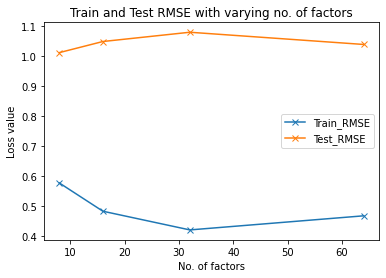

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dim, train_rmse, label = "Train_RMSE",marker="x")
plt.plot(dim, test_rmse, label = "Test_RMSE",marker="x")
plt.xlabel('No. of factors')
plt.ylabel('Loss value')
plt.title('Train and Test RMSE with varying no. of factors') 
plt.legend() 
plt.savefig('train_test_rmse.png',bbox_inches='tight')
plt.show()

## Evaluating Other Models

When evaluating models, it's important to compare to some reasonable baselines. 

Fortunately, Spotlight's `rmse_score()` method can be used to evaluate any Python object that adheres to the specification of the `predict()` function. For instance, we can make a baseline "static" scoring model, which returns the same scores for each user. This set of scores is passed as numpy array in the constructor.


In [ ]:
class StaticModel:
  
  def __init__(self, staticscores):
    self.numitems = len(staticscores)
    self.staticscores = staticscores
  
  #uids are the user(s) we are requesting recommendations for;
  #returns an array of scores, one for each item
  #the array is duplicated for each user requested
  def predict(self, uids, iids=None):
    #this model returns all zeros, regardless of userid
    
    #we respond to one or more uids
    uids = [uids] if isinstance(uids, int) else uids

    #if iids is specificed, we filter predicts for those userids
    iids = np.arange(self.numitems) if iids is None else iids
    return [self.staticscores[iids] for u in uids]

For instance, we can make a static baseline that just returns 0 for every item, regardless of the user.

In [ ]:
mydummymodel = StaticModel(np.zeros(num_items))

print("Asking for 2 users, one item: " + str(mydummymodel.predict([0,1],0)))
print("Asking for one item: " + str(mydummymodel.predict(0,0)))
print("Asking for two items: " + str(mydummymodel.predict(0,[0,1])))
print("RMSE of our dummy model: %f" % rmse_score(mydummymodel, test))

Asking for 2 users, one item: [0.0, 0.0]
Asking for one item: [0.0]
Asking for two items: [array([0., 0.])]
RMSE of our dummy model: 3.642758


## Task 6. Popularity-based Recommenders

This task asks you to implement other baseline recommenders.

**Using ratings_df**, create three new instances of StaticModel as baselines:

(a). the number of ratings for each item - you must linearly normalise this to be in the range 0-5.

(b). the number of 5 scores received by an item - you must linearly normalise this to be in the range 0-5.

(c). the average rating value for each item (no need to normalise - scores are already 0-5)

Evaluate your baseline models in terms of RMSE, as well as providing their scores for particular iids, as requested in the quiz.

Hints:
 - You may find iterating over a dataframe using iterrows() useful - e.g. see  https://stackoverflow.com/a/16476974
 - Order is VERY IMPORTANT. Think carefully about the assumed order that predict() returns item scores for.

In [ ]:
#6A
ratings=np.zeros(num_items)
mydf=ratings_df.groupby(by=['movieId']).count()
for i,j in mydf.iterrows():
  ratings[iid_map[i]]=j['rating']
ratings=(ratings/max(ratings)*5)
model1=StaticModel(ratings)
print("RMSE of my 1st dummy model 1 is : %f" % rmse_score(model1,test))

RMSE of my 1st dummy model 1 is : 2.887788


In [ ]:
#6A
print("Asking for one item: " + str(model1.predict(0,0)))

Asking for one item: [3.2674772036474167]


In [ ]:
#6B
ratings_df[(ratings_df['movieId']=='m10') & (ratings_df['rating']==5)].count()

userId       10
movieId      10
rating       10
timestamp    10
dtype: int64

In [ ]:
#6B
ratings=np.zeros(num_items)
mydf=ratings_df[ratings_df['rating']==5]
mydf=mydf.groupby(['movieId']).count()
for i,j in mydf.iterrows():
  ratings[iid_map[i]]=j['rating']
ratings=(ratings/max(ratings)*5)
model2=StaticModel(ratings)
print("RMSE of my 1st dummy model 1 is : %f" % rmse_score(model2,test))

RMSE of my 1st dummy model 1 is : 3.308017


In [ ]:
#6B
print("Asking for one item: " + str(model2.predict(0,0)))

Asking for one item: [1.5359477124183007]


In [ ]:
#6C
ratings=np.zeros(num_items)
mydf=ratings_df.groupby(by=['movieId']).mean()
for i,j in mydf.iterrows():
  ratings[iid_map[i]]=j['rating']
#ratings=(ratings/max(ratings)*5)
model3=StaticModel(ratings)
print("RMSE of my 1st dummy model 3 is : %f" % rmse_score(model3,test))

RMSE of my 1st dummy model 3 is : 0.881075


In [ ]:
#6C
print("Asking for one item: " + str(model3.predict(0,0)))

Asking for one item: [3.9209302325581397]


# Part C - Implicit Recommendation

This part of the lab uses a music dataset from [Last.fm](https://www.last.fm/) -- a Spotify-like music streaming service -- that was obtained by a researcher at Pompeu Fabra University (Barcelona, Spain). The relevant citation is:

```
  @book{Celma:Springer2010,
      	author = {Celma, O.},
      	title = {{Music Recommendation and Discovery in the Long Tail}},
       	publisher = {Springer},
       	year = {2010}
      }
 ```

You can have more information about the dataset at [this link](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html).

## Dataset preparation

This dataset is 600MB copmressed, and 2.4GB uncompressed. It takes 30 seconds to download on Colab. 

In [ ]:
!rm -rf lastfm-dataset-1K.tar.gz
!curl -o "lastfm-dataset-1K.tar.gz" "http://www.dcs.gla.ac.uk/~craigm/recsysH/lastfm-dataset-1K.tar.gz"
#backup location
#!curl -o "lastfm-dataset-1K.tar.gz" http://macavaney.us/misc/lastfm-dataset-1K.tar.gz
!tar -zxvf lastfm-dataset-1K.tar.gz
!ls -lh lastfm-dataset-1K/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  641M  100  641M    0     0  27.4M      0  0:00:23  0:00:23 --:--:-- 28.9M
lastfm-dataset-1K/
lastfm-dataset-1K/userid-profile.tsv
lastfm-dataset-1K/README.txt
lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv
total 2.4G
-rw-r--r-- 1 1002 1002 2.2K Mar 23  2010 README.txt
-rw-r--r-- 1 1002 1002  37K Dec 30  2009 userid-profile.tsv
-rw-r--r-- 1 1002 1002 2.4G Mar  4  2010 userid-timestamp-artid-artname-traid-traname.tsv


In [ ]:
listens_df = pd.read_csv("lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv",  names=['user', 'timestamp', 'artistid', 'artist', 'trackid', 'trackname'], header=None, sep='\t')

#Some tracks dont seem to have artists or track names, so lets drop them for simplicity.
listens_df = listens_df[listens_df.artist.notnull()]
listens_df = listens_df[listens_df.trackname.notnull()]

#the dataframe is VERY big (19M interactions), so lets just work with a small sample of it (this will mean that effectiveness will be lower, but learning will be MUCH faster).
listens_df = listens_df.sample(n=200000, random_state=np.random.RandomState(SEED))


Let's look at the dataset. Note that the we don't have any explicit ratings by the users. We just know what they interacted with (and when). 

In [ ]:
listens_df.head()

,user,timestamp,artistid,artist,trackid,trackname
11087179,user_000593,2007-05-14T18:49:03Z,ad996aef-cc1c-42ac-af5c-619c370f4b8a,"Emerson, Lake & Palmer",NaN,Three Fates (Clotho/Lachesis/Atropos)
1911790,user_000093,2008-08-18T22:04:59Z,8c538f11-c141-4588-8ecb-931083524186,Bloc Party,315a301e-e764-4adf-91c6-e90a22320106,Positive Tension
11099786,user_000594,2008-04-06T10:57:45Z,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,683c89fe-2be8-4ed2-8e58-68b2343cb8d5,Through The Never
12076983,user_000651,2008-05-10T07:14:45Z,3ca09fae-fdee-4771-bab9-244708515a98,Omarion,NaN,Ice Box [Orangefuzzz Weather Advisory Radio Mix]
2680461,user_000137,2009-03-11T23:17:22Z,af84ee9f-534a-4f7f-844b-188ba1c47e87,Los Rodríguez,76b83f07-3763-4c17-8d24-28040d85354a,Dulce Condena


## An implicit recommendation approach

Let's move away from explicit recommendation to implicit.

We will continue using the [Spotlight](https://github.com/maciejkula/spotlight/) toolkit for our recommender. 

We can construct [Interaction](https://maciejkula.github.io/spotlight/interactions.html) objects for Spotlight in the same way as before. The only difference is that this time we do not record the user's ratings.


In [ ]:
from collections import defaultdict
from itertools import count

#we cant trust the musicbrainz ids to exist, so lets build items ids based on artist & trackname attributes
LFMiid_map = defaultdict(count().__next__)
LFMiids = np.array([LFMiid_map[artist+"/"+trackname] for artist,trackname in listens_df[["artist","trackname"]].values ], dtype=np.int32)

LFMuid_map = defaultdict(count().__next__)
LFMuids = np.array([LFMuid_map[uid] for uid in listens_df["user"].values ], dtype=np.int32)
#freeze uid_map and iid_map so no more mapping are created
LFMuid_map.default_factory = None
LFMiid_map.default_factory = None

LFMuid_rev_map = {v: k for k, v in LFMuid_map.items()}
LFMiid_rev_map = {v: k for k, v in LFMiid_map.items()}

from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

#NB: we will set num_users and num_items here - its a good practice.
imp_dataset = Interactions(user_ids=LFMuids, item_ids=LFMiids, num_users=len(LFMuid_map), num_items=len(LFMiid_map))
#we could add the timestamps here if we were doing sequence recommendation

#what have we got.
print(imp_dataset)
LFMiids

<Interactions dataset (973 users x 125076 items x 200000 interactions)>


array([     0,      1,      2, ..., 125074, 125075,   2602], dtype=int32)

In [ ]:
LFMiid_rev_map.get(LFMiids[2602])

'Mariah Carey/We Belong Together (Peter Rauhofer Radio Edit)'

In [ ]:
from spotlight.cross_validation import random_train_test_split

itrain, itest = random_train_test_split(imp_dataset, random_state=np.random.RandomState(SEED))
print(itrain)
print(itest)

<Interactions dataset (973 users x 125076 items x 160000 interactions)>
<Interactions dataset (973 users x 125076 items x 40000 interactions)>


Let's run Spotlight's impllicit Matrix Factorisation on this dataset. Here, we use a *pointwise* loss, which just tries to predict whether the user will like the item or not. It does not use the BPR loss function (more on that later).

**Warning**: this dataset is difficult for the learner - this *will* take a few minutes to learn... Use the time to read-on.

In [ ]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  

imodel = ImplicitFactorizationModel(n_iter=5, 
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

imodel.fit(itrain, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds" % (diff))

Epoch 0: loss 0.9663112537384033
Epoch 1: loss 0.4953250964164734
Epoch 2: loss 0.19036926743984223
Epoch 3: loss 0.11518938970565797
Epoch 4: loss 0.08347186335921288
Training took 164 seconds


Again, we can look at the predictions. We make a prediction (a score ) for ALL items for user uid 0. Note that the scores vary in magnitude - indeed, we're not predicting a rating, we just need to have scores in order to rank the items in descending order.

In [ ]:
print(imodel.predict(4))
print(len(imodel.predict(4)))


[ -8.309335    2.8038096  -7.2378526 ...  -4.77122    -9.353735
 -10.95487  ]
125076


Now that we have the scores of all items for a given user, we need to identify the top-scored ones, i.e. those that we would present to the user. 

## Task 7. Track Analysis

Write a function `tracksForUser(user)` to identify the artist name & track of the top K (e.g. K=4) items based on their score for a given user index index (i.e. 0.. 964). What are the top scored 10 tracks recommended for user uid 4?

Hints: 

 
 - I also found [`np.argwhere()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argwhere.html) to be useful. It results only the positions of an array that are True. For instance:
```
>>> np.argwhere([True, False])
array([[0]])
```
 Alternatively, you can sort and then slice.



In [ ]:
def tracksForUser(user):
  k=10
  y=imodel.predict(user)
  rank=rankdata(y, method='ordinal').astype(int)
  rank=len(rank) - rank
  rank=rank+1
  rank=rank.tolist()
  for s in range(1,k+1):
    r=rank.index(s)
    print(LFMiid_rev_map.get(r))
tracksForUser(4)

Evanescence/Sweet Sacrifice
Mgmt/Kids
The Killers/Bones
Nelly Furtado/Say It Right
Kings Of Leon/Use Somebody
Amy Winehouse/Back To Black
Red Hot Chili Peppers/The Zephyr Song
Radiohead/Fake Plastic Trees
Incubus/Drive
Him/The Funeral Of Hearts


In [ ]:
LFMiid_rev_map.get(LFMiids[7010])

'Blood On The Wall/The X'

## Task 8. Artist Analysis

Look at the artists actually listened to by uid 4, and compare/contrast with the predictions of the recommender. It's useful to examine how many times each artist was listened to.

Hints: 
 - use a groupby on a suitable subset of the listens_df dataframe. 
 - Sort by descending frequency of listen.

In [ ]:
x=listens_df[listens_df['user']==LFMuid_rev_map.get(4)]
x=x[['user','artist','trackname']].groupby(by=['artist']).count()
x.sort_values(by=['user'], ascending=False).head(10)

,user,trackname
artist,,
Soda Stereo,39,39
Gustavo Cerati,36,36
Radiohead,31,31
Lucybell,27,27
Silvio Rodríguez,16,16
Coldplay,13,13
Dream Theater,13,13
Muse,11,11
Daniel Garcia,11,11


I observed that uid 4 listened frequently to "Radiohead" (rank 3), while a Radiohead song was among the top 10 ranked songs in our predicted model.

## Evaluating an implicit recommender




We can examine the MRR of the implicit model we have learned. We pass it the test set (which contains knowledge of what the user *actually* clicked), as our ground truth. 

In the second variant, we also pass the training data. Give a look at the  implementation of [mrr_score()](https://github.com/cmacdonald/spotlight/blob/master/spotlight/evaluation.py#L8) to understand what it is doing, and why.

**Questions for you to consider**
 - Why is the second score lower? 
 - Would this be the same for all recommendation settings? 
 - In the implementation, why are the scores negated, why do we use [rankdata()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rankdata.html)?
 
We will use the first variant for this Lab. 

In [ ]:
from spotlight.evaluation import mrr_score

#evaluate on this dataset takes approx 1 minute
!date
print(mrr_score(imodel, itest).mean())
!date
print(mrr_score(imodel, itest,  train=itrain).mean())
!date


Wed Aug  4 14:19:13 UTC 2021
0.03720125940064275
Wed Aug  4 14:19:50 UTC 2021
0.008104536778740273
Wed Aug  4 14:20:27 UTC 2021


How to interpret an MRR score - we know it has a range [0,1] with 1 being best. 1 means, on average across all users, we make a relevant prediction at rank 1; 0.5 means, on average, at rank 2. This is a very rough rule-of-thumb - MRR isn't a linear measure, so  a few poor predictions affect the average more than a few good ones.


You can now answer all questions for Task 8.

## Task 9. Listens and Recommendations

*   Pick the user with the lowest uid that has RR=1 (you should not specify `train=` when making this choice). How many listens (ie. how many times they have listened to any song) did they have in the training dataset?
*   Similarly, pick the user with the lowest uid that had the lowest RR. How many listens did they have in the training dataset?



In [ ]:
all_mrr = mrr_score(imodel, itest)

In [ ]:
i = np.where(all_mrr == 1)
print(all_mrr)
print(i)
print("1st user with rr=1:",LFMuid_rev_map.get(i[0][0]))
#len(itrain.item_ids[itrain.user_ids == i[0][0]])
min_i=min(i)[0]
print("min_id with 1 mrr is ",min_i)
print(len(itrain.item_ids[itrain.user_ids == min_i]))

[0.2        0.         0.33333333 0.         0.25       0.
 0.         0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.11111111 0.
 0.14285714 0.         0.         0.         0.         0.25
 0.         0.         0.         0.16666667 0.         0.
 0.         1.         0.         0.33333333 0.         0.14285714
 1.         0.         0.         0.         0.         0.
 0.5        0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.1
 0.1        0.         0.         0.16666667 1.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.11111111 0.         0.         0.
 0.         0.5        0.         0.         0.         0.
 0.         0.14285714 0.         0.         

In [ ]:
j = np.where(all_mrr == 0)
#print(j)
print("1st user with rr=1:",LFMuid_rev_map.get(j[0][0]))
min_j=min(j)[0]
print("min_id is with 0 mrr ",min_j)
print(len(itrain.item_ids[itrain.user_ids == min_j]))

1st user with rr=1: user_000093
min_id is with 0 mrr  1
355


Next, make a numpy array containing the number of listens for each uid in the LastFM dataset. Plot a histogram of the distribution - like in Exercise 1, use matplotlib's histogram functionality, the default number of bins and use `log=True`. 

Save the PNG for uploading to the quiz when prompted.

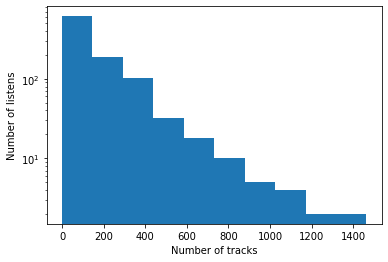

In [ ]:
total = []
for i in range(len(all_mrr)):
  total.append(len(itrain.item_ids[itrain.user_ids == i]))
total = np.array(total)
#plt.figure(figsize=(7,7))
plt.hist(total, log=True)
plt.xlabel('Number of tracks')
plt.ylabel('Number of listens')
plt.savefig('ListenDF.png')
plt.show()

In [ ]:
new_users = []
for i in range(len(all_listens)):
  if all_listens[i] < 20:
    new_users.append(i)
mrr_new_users, mrr_normal = {}, {}
for i in range(len(all_mrr)):
  if i in new_users:
    mrr_new_users[i] = all_mrr[i]
  else:
    mrr_normal[i] = all_mrr[i]
total_new=0
for i,j in mrr_new_users.items():
  total_new += j
print(total_new/len(mrr_new_users))
total_normal=0
for i,j in mrr_normal.items():
  total_normal += j
print(total_normal/len(mrr_normal))

0.0024250440917107582
0.044147926330417094


Many users have very few listens. Lets set 20 listens as a threshold.

Lets define users with < 20 listens as cold-start users.
How many cold-start users are there?
What is the MRR for ONLY these users, versus "normal" with 20 or more listens.


## Task 10 - BPR

Finally, let's compare the *pointwise* implicit factorisation model with *BPR*. BPR is a very key recommendation model in the literature, which is widely used today as a baseline in many research papers.

Train an ImplicitFactorizationModel on the Last FM dataset (i.e. `itrain`) using identical settings as before, except adding `loss='bpr'`. Record the time taken to train, and the evaluate its effectiveness in terms of MRR. Do NOT use the `train=itrain` argument to `mrr_score()`. 

In [ ]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  

imodel_2 = ImplicitFactorizationModel(n_iter=5, 
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    loss='bpr',
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

imodel_2.fit(itrain, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds" % (diff))
print(round(mrr_score(imodel_2, itest).mean(),4))

Epoch 0: loss 0.4740972354888916
Epoch 1: loss 0.14683696522712708
Epoch 2: loss 0.024808155296742917
Epoch 3: loss 0.014375447143614292
Epoch 4: loss 0.01111387666836381
Training took 165 seconds
0.0581


# End of Exercise

As part of your submission, you should complete the Exercise 2 quiz on Moodle.
You will need to upload your notebook, complete with the **results** of executing the code (including figures and plots).